# Models training
In this notebook we train and analyze multiple models, compare them and tune them to get the best results. We will work with a small subset due to low hardware availability.

# 1.0 Unsupervised
We first try and distinguish the words without letting the model know the labels.

# 1.1 Dynamic Time Wrapping and KMeans (DTW)

In [ ]:
# After Kernel restart you can sgtart here.
import pandas as pd
import os
import numpy as np
import pickle
from collections import Counter

with open('landmarks_subset_proccessed.pkl', 'rb') as file:
    subset_landmarks = pickle.load(file)

data_info = pd.read_csv('video_labels.csv',dtype={'video_id': object})
subset_words = ['tall', 'man', 'red', 'shirt', 'play', 'basketball', 'cold', 'pizza', 'top', 'cheese', 'taste',
                'delicious', 'lazy', 'afternoon', 'dark', 'room', 'small', 'lamp', 'empty',
                'big', 'dog', 'walk', 'beautiful', 'every', 'morning', 'short',
                'woman', 'wear', 'dress', 'have', 'beautiful', 'daughter']


POSE = np.hstack((np.ones(33), np.zeros(21+21+468))) == 1
LH = np.hstack((np.zeros(33), np.ones(21), np.zeros(21+468))) == 1
RH = np.hstack((np.zeros(33+21), np.ones(21), np.zeros(468))) == 1
FACE = np.hstack((np.zeros(33+21+21), np.ones(468))) == 1
videos_per_word = Counter(data_info.loc[data_info.word.isin(subset_words),'word'])

## 3.1 Sainity chack with DTW
Dynamic Time Wrapping can detect similar motions but its computation is slow, let's take videos of two words only, without the face (which has the majority of landmarks) and check whether it is a good approach.

In [ ]:
words = ["play","basketball","morning","tall","dress","beautiful"]
for word in words:
    print(word, videos_per_word[word])

dtw_landmarks = {}
for word in words:
    videos = data_info.loc[data_info.word==word,'video_id']
    for vid in videos[:2]:
        dtw_landmarks[vid] = subset_landmarks[vid][::3,POSE+LH+RH,:] # Exclude augmented videos for now
len(dtw_landmarks)

play 11
basketball 12
morning 6
tall 13
dress 8


10

/Users/oren/anaconda3/envs/ai/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


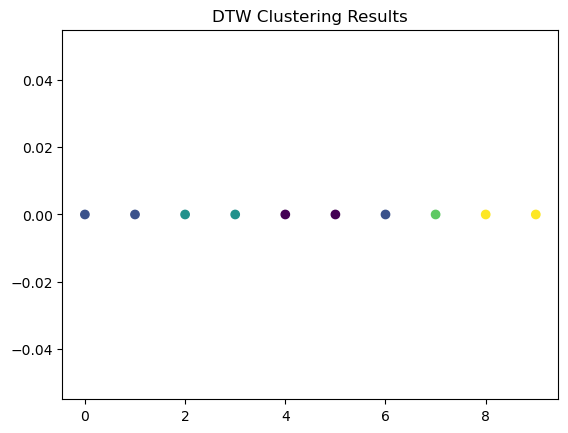

['play', 'basketball', 'morning', 'tall', 'dress']


In [ ]:
import numpy as np
from fastdtw import fastdtw
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Function to compute DTW distance between two sequences
def dtw_distance(seq1, seq2):
    distance, path = fastdtw(seq1, seq2)
    return distance

# Function to perform clustering using DTW
def dtw_cluster(video_landmarks, num_clusters):
    # Flatten the video landmarks into sequences
    sequences = [frame.flatten() for frame in video_landmarks]

    # Compute pairwise DTW distances
    num_frames = len(video_landmarks)
    distances = np.zeros((num_frames, num_frames))
    for i in range(num_frames):
        for j in range(i + 1, num_frames):
            distances[i, j] = dtw_distance(sequences[i], sequences[j])
            distances[j, i] = distances[i, j]

    # Perform KMeans clustering based on DTW distances
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(distances)

    return labels

# Example usage
# Assuming 'video_landmarks' is a list of 2D arrays representing landmarks for each frame
# You can adjust 'num_clusters' based on your requirements
num_clusters = len(words)
cluster_labels = dtw_cluster(dtw_landmarks.values(), num_clusters)

# Visualize the clustering results
plt.scatter(range(len(dtw_landmarks)), [0] * len(dtw_landmarks), c=cluster_labels, cmap='viridis')
plt.title('DTW Clustering Results')
plt.show()
print(words)